## 練習時間
將你的結果存成 csv, 上傳你的第一份 Kaggle 成績

Hints: https://stackoverflow.com/questions/16923281/pandas-writing-dataframe-to-csv-file

# [作業目標]
- 檢視並重新執行腳本, 試著將執行結果存檔並提交到 Kaggle 上

# [作業重點]
- 執行後, 將所得結果, 存成可以提交的 csv 檔 (In[10]) (Hint : 使用 pandas.DataFreame.to_csv)

# [提醒]
- 執行後, 將所得結果, 存成可以提交的 csv 檔 (In[10]) (Hint : 使用 pandas.DataFreame.to_csv)

In [1]:
# 載入需要的套件
import os
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### 仿造之前做過的處理

In [2]:
# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

# 讀取檔案
app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

In [3]:
# 種類 2 種以下的類別型欄位轉標籤編碼 (Label Encoding)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # 紀錄有多少個 columns 被標籤編碼過
            le_count += 1
            
# 標籤編碼 (2種類別) 欄位轉 One Hot Encoding            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

### 做好前處理
開始擬合模型之前，我們要確保 training & testing data 的欄位數量一致，原因是因為 One hot encoding 會製造多的欄位，有些類別出現在 training data 而沒有出現 testing data 中，我們就要把這些多餘的欄位去除

In [5]:
train_labels = app_train['TARGET']

# 調整欄位數, 移除出現在 training data 而沒有出現 testing data 中的欄位
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

In [6]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# 特徵欄位清單
train = app_train
features = list(train.columns)

# 複製 test 資料
test = app_test.copy()

# 填補器 : 設定缺失值補中位數
imputer = Imputer(strategy = 'median')

# 縮放器 : 設定特徵縮放到 0~1 區間
scaler = MinMaxScaler(feature_range = (0, 1))

# 填補器載入個欄中位數
imputer.fit(train)

# 將中位數回填 train, test 資料中的空缺值
train = imputer.transform(train)
test = imputer.transform(app_test)

# 縮放器載入 train 的上下限, 對 train, test 進行縮放轉換
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


### Fit the model

In [7]:
from sklearn.linear_model import LogisticRegression

# 設定模型與模型參數
log_reg = LogisticRegression(C = 0.0001)

# 使用 Train 資料訓練模型
log_reg.fit(train, train_labels)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

模型 fit 好以後，就可以用來預測 testing data 中的客戶違約遲繳貸款的機率咯! (記得要用 predict_proba 才會輸出機率)

In [8]:
# 用模型預測結果
# 請注意羅吉斯迴歸是分類預測 (會輸出 0 的機率, 與 1 的機率), 而我們只需要留下 1 的機率這排
log_reg_pred = log_reg.predict_proba(test)[:, 1]

### 儲存預測結果

In [9]:
# 計算提交結果
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SK_ID_CURR,TARGET
0,100001,0.065051
1,100005,0.126401
2,100013,0.081239
3,100028,0.061509
4,100038,0.128308


In [14]:
submit.to_csv('./HW21.csv', index = False)

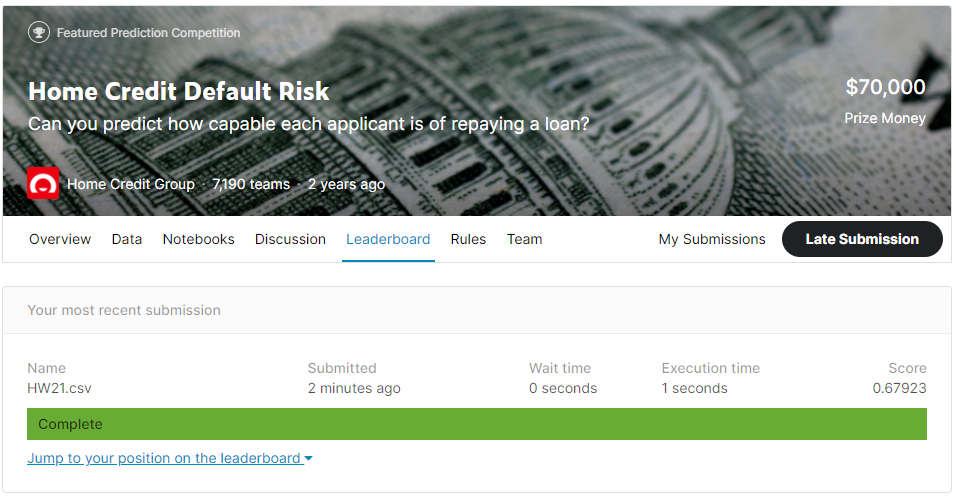